# Alignment tutorial for 151673 and 151674 from DLPFC
In this tutorial, we will demonstrate how to implement 151673 and 151674 alignment using 3d-OT and calculate the chamfer distance

## Loading package

In [1]:
from lib_3d_OT.utils import *
import scanpy as sc
import numpy as np
import pandas as pd
import torch
from lib_3d_OT.single_modialty import *
import torch.optim as optim
import warnings
warnings.filterwarnings("ignore")

During startup - Warning messages:
1: package ‘methods’ was built under R version 4.3.2 
2: package ‘datasets’ was built under R version 4.3.2 
3: package ‘utils’ was built under R version 4.3.2 
4: package ‘grDevices’ was built under R version 4.3.2 
5: package ‘graphics’ was built under R version 4.3.2 
6: package ‘stats’ was built under R version 4.3.2 
R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.1.1
Type 'citation("mclust")' for citing this R package in publications.



In [2]:
import os
os.environ['R_HOME'] = '/home/dbj/anaconda3/envs/r/lib/R'
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

## Loading and Pre-processing two slices from 151673 and 151674
+ First, we need to prepare the single cell spatial data into AnnData objects. AnnData is the standard data class we use in 3d-OT. 
+ See [documentation](https://anndata.readthedocs.io/en/latest/index.html) for more details if you are unfamiliar, including how to construct AnnData objects from scratch, and how to read data in other formats (csv, mtx, loom, etc.) into AnnData objects.
+ `dpca` is the preprocessing process for reference [SLAT](https://www.nature.com/articles/s41467-023-43105-5).

In [3]:
adata1=sc.read_visium('/home/dbj/mouse/DLPFC/DLPFC/151673/')
adata1.var_names_make_unique()
truth = pd.read_csv('/home/dbj/mouse/vision/spatial/DLPFC_annotations/151673_truth.csv', sep='\t', index_col=0)
adata1.obs['truth'] = truth.iloc[:,0]
adata1 = adata1[~adata1.obs['truth'].isna(), :]

adata2=sc.read_visium('/home/dbj/mouse/DLPFC/DLPFC/151674/')
adata2.var_names_make_unique()
truth = pd.read_csv('/home/dbj/mouse/vision/spatial/DLPFC_annotations/151674_truth.csv', sep='\t', index_col=0)
adata2.obs['truth'] = truth.iloc[:,0]
adata2 = adata2[~adata2.obs['truth'].isna(), :]

In [4]:
adatalist=[adata1,adata2]
adata1,adata2=dpca(adatalist,n_comps=50,join='inner')

## Constructing neighbor graph and training the Pointnet++Encoder
We first build the neighbor graph `graph1` of 151673 and train the encoder to get a trained encoder `best_model1`

In [5]:
set_seed(7)
graph1 = prepare_data(adata1, location="spatial", nb_neighbors=8).to(device)
input_dim1 = graph1.express.shape[-1]
model = extractMODEL(args=None,input_dim=input_dim1)
optimizer = optim.Adam(model.parameters(), lr=0.001)
best_model1, min_loss = train_graph_extractor(graph1, model, optimizer, device,epochs=800)

Epoch 800/800, Loss: 2.200454, Min Loss: 2.212034

## Constructing neighbor graph and training the Pointnet++Encoder
We then build the neighbor graph `graph2` of 151674 and train the encoder to get a trained encoder `best_model2`

In [6]:
set_seed(7)
graph2 = prepare_data(adata2, location="spatial", nb_neighbors=8).to(device)
input_dim2 = graph2.express.shape[-1]
model = extractMODEL(args=None,input_dim=input_dim2)
optimizer = optim.Adam(model.parameters(), lr=0.001)
best_model2, min_loss = train_graph_extractor(graph2, model, optimizer, device,epochs=800)

Epoch 800/800, Loss: 2.350463, Min Loss: 2.356186

## Source align slice truth 

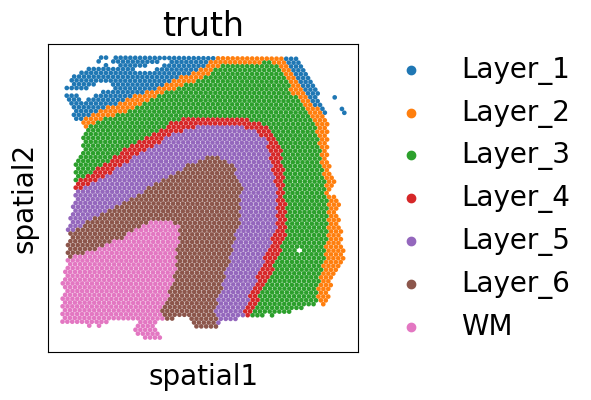

In [7]:
import matplotlib.pyplot as plt
import copy
plt.rcParams['figure.figsize'] = (4,4)
plt.rcParams['font.size'] = 20
adata1_rotated = copy.deepcopy(adata1)
coords = adata1_rotated.obsm['spatial']

adata1_rotated.obsm['spatial'] = np.column_stack((coords[:, 0],-coords[:, 1]))
fig, ax = plt.subplots()
sc.pl.embedding(adata1_rotated,basis='spatial',color='truth',size=45,ax=ax)

## Target align slice truth 

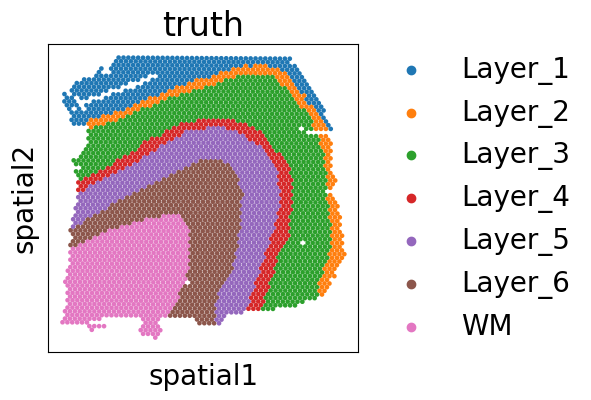

In [8]:
import matplotlib.pyplot as plt
import copy
plt.rcParams['figure.figsize'] = (4,4)
plt.rcParams['font.size'] = 20
adata2_rotated = copy.deepcopy(adata2)
coords = adata2_rotated.obsm['spatial']

adata2_rotated.obsm['spatial'] = np.column_stack((coords[:, 0],-coords[:, 1]))
fig, ax = plt.subplots()
sc.pl.embedding(adata2_rotated,basis='spatial',color='truth',size=45,ax=ax)

## Training the optimal transport module
Enter graph1 and graph2 and the two encoders we trained into the optimal transport model

In [10]:
pclouds_list=[graph1,graph2]

In [11]:
input_dim1 = pclouds_list[0].express.shape[-1]
input_dim2 = pclouds_list[1].express.shape[-1]
model = UnifiedModel(input_dim1=input_dim1,input_dim2=input_dim2,simk=5,otk=20,reconk=1,best_encoder1=best_model1,best_encoder2=best_model2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
lr_lambda = lambda epoch: 1.0 if epoch < 340 else 1.0
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)
args = {
    "backward_dist_weight":1.0,
    "use_smooth_flow":1,
    "smooth_flow_loss_weight":1.0,
    "use_div_flow":1,
    "div_flow_loss_weight":1.0,
    "div_neighbor": 8,
    "lattice_steps": 10,
    "nb_neigh_smooth_flow":32,
}



train(model=model,pcloud_list=pclouds_list,optimizer=optimizer,scheduler=scheduler,device=device,nb_epochs=1,use_corr_conf=False,use_smooth_flow=True,use_div_flow=True,args=args)

Time Pair 0,total_loss: 0.0586,smooth_flow_loss: 0.0404 Target Recon Loss: 0.00010402,Div Flow Loss: 0.0181

## Visualize and quantify the evaluation of seven region alignment results
+ `selected_cell_type` represents the drawn source cell type
+ `finaltruth` means that the target cell type corresponding to the source cell type that based on the biological understanding, and it is used to obtain the spatial location information of the target cell type and calculate the chamfer distance
+ `all_arrow_ends` represents all aligned flow end positions from source cell type,it is used to calculate the chamfer distance
+ `layer_1_pcloud_3D` represents the target cell type spatial position information based on biological understanding, and is used to calculate the chamfer distance

## Layer_1 alignment result

Number of arrow ends: 273
Layer 1 points count: 380


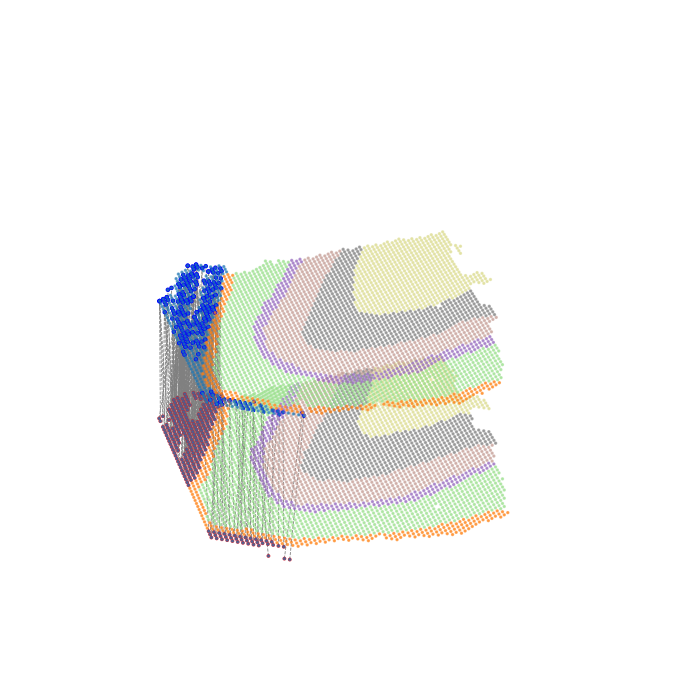

In [26]:
from lib_3d_OT.plot import *
all_arrow_ends,layer_1_pcloud_3D=plot_selected_cell_type_flow(pclouds_list, model, device,selected_cell_type='Layer_1',finaltruth=['Layer_1'],xlim=(-0.1, 1.1),ylim=(-0.1, 1.1),height_scale=1,size=2,alpha=0.6,
    #save_path='/home/dbj/DPLFC/'
)

`-Log10(chamfer_distance)` as a performance metric for alignment

In [13]:
chamfer_dist = chamfer_distance(all_arrow_ends,layer_1_pcloud_3D)

print(f"chamfer distance: {chamfer_dist}")

chamfer distance: 0.0003613015316660893


## Layer_2 alignment result

Number of arrow ends: 253
Layer 1 points count: 224


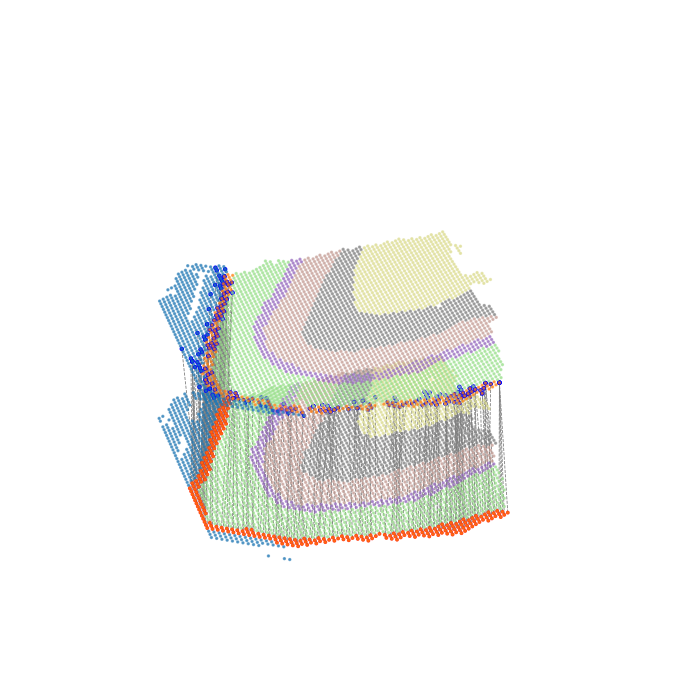

In [14]:
from lib_3d_OT.plot import *
all_arrow_ends,layer_1_pcloud_3D=plot_selected_cell_type_flow(pclouds_list, model, device,selected_cell_type='Layer_2',finaltruth=['Layer_2'],xlim=(-0.1, 1.1),ylim=(-0.1, 1.1),height_scale=1,size=2,alpha=0.6,
    #save_path='/home/dbj/DPLFC/'
)

In [15]:
chamfer_dist = chamfer_distance(all_arrow_ends,layer_1_pcloud_3D)

print(f"chamfer distance: {chamfer_dist}")

chamfer distance: 0.0003549892395294974


## Layer_3 alignment result

Number of arrow ends: 988
Layer 1 points count: 923


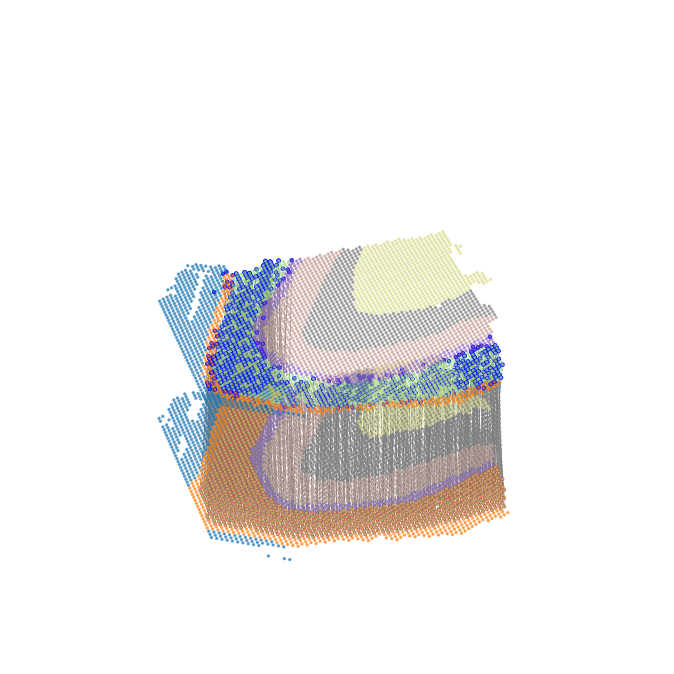

In [16]:
from lib_3d_OT.plot import *
all_arrow_ends,layer_1_pcloud_3D=plot_selected_cell_type_flow(pclouds_list, model, device,selected_cell_type='Layer_3',finaltruth=['Layer_3'],xlim=(-0.1, 1.1),ylim=(-0.1, 1.1),height_scale=1,size=2,alpha=0.6,
    #save_path='/home/dbj/DPLFC/'
)

In [27]:
chamfer_dist = chamfer_distance(all_arrow_ends,layer_1_pcloud_3D)

print(f"chamfer distance: {chamfer_dist}")

chamfer distance: 0.0003613015316660893


## Layer_4 alignment result

Number of arrow ends: 218
Layer 1 points count: 247


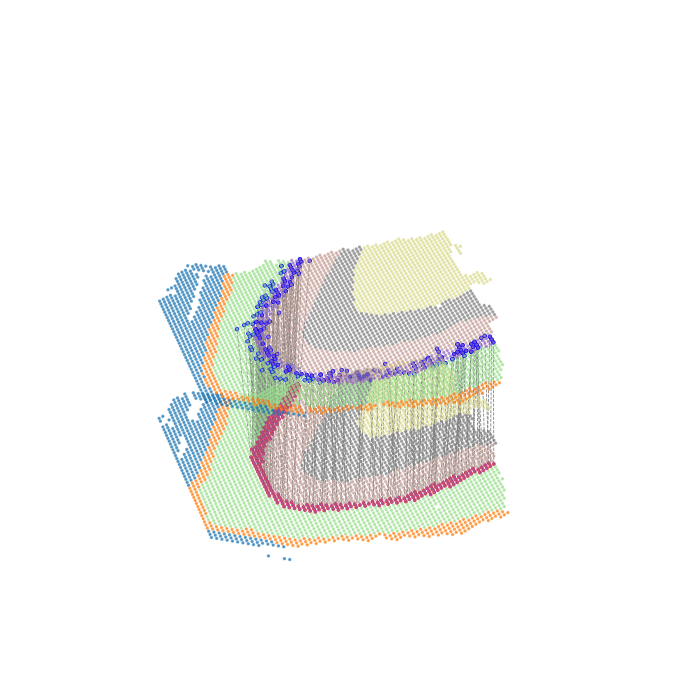

In [18]:
from lib_3d_OT.plot import *
all_arrow_ends,layer_1_pcloud_3D=plot_selected_cell_type_flow(pclouds_list, model, device,selected_cell_type='Layer_4',finaltruth=['Layer_4'],xlim=(-0.1, 1.1),ylim=(-0.1, 1.1),height_scale=1,size=2,alpha=0.6,
    #save_path='/home/dbj/DPLFC/'
)

In [19]:
chamfer_dist = chamfer_distance(all_arrow_ends,layer_1_pcloud_3D)

print(f"chamfer distance: {chamfer_dist}")

chamfer distance: 0.0004005055165088926


### Layer_5 alignment result

Number of arrow ends: 673
Layer 1 points count: 621


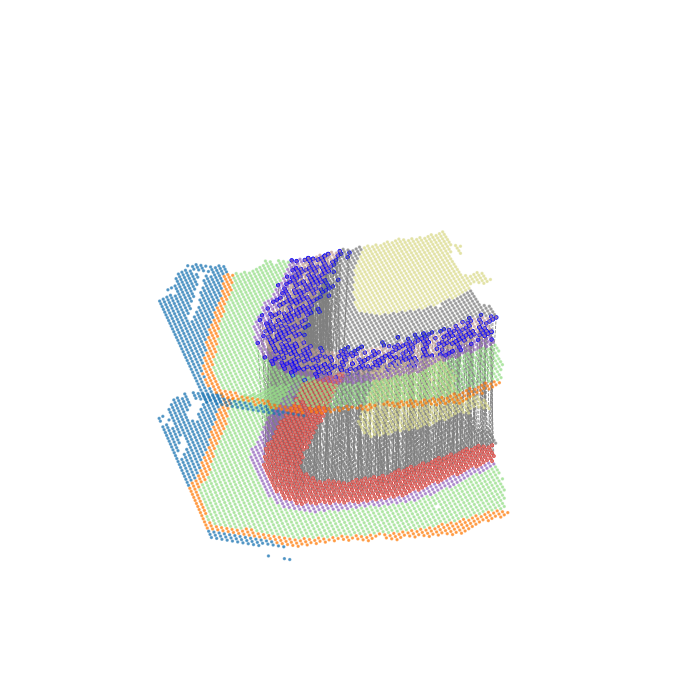

In [20]:
from lib_3d_OT.plot import *
all_arrow_ends,layer_1_pcloud_3D=plot_selected_cell_type_flow(pclouds_list, model, device,selected_cell_type='Layer_5',finaltruth=['Layer_5'],xlim=(-0.1, 1.1),ylim=(-0.1, 1.1),height_scale=1,size=2,alpha=0.6,
    #save_path='/home/dbj/DPLFC/'
)

In [21]:
chamfer_dist = chamfer_distance(all_arrow_ends,layer_1_pcloud_3D)

print(f"chamfer distance: {chamfer_dist}")

chamfer distance: 0.0002188742874835671


### Layer_6 alignment result

Number of arrow ends: 692
Layer 1 points count: 614


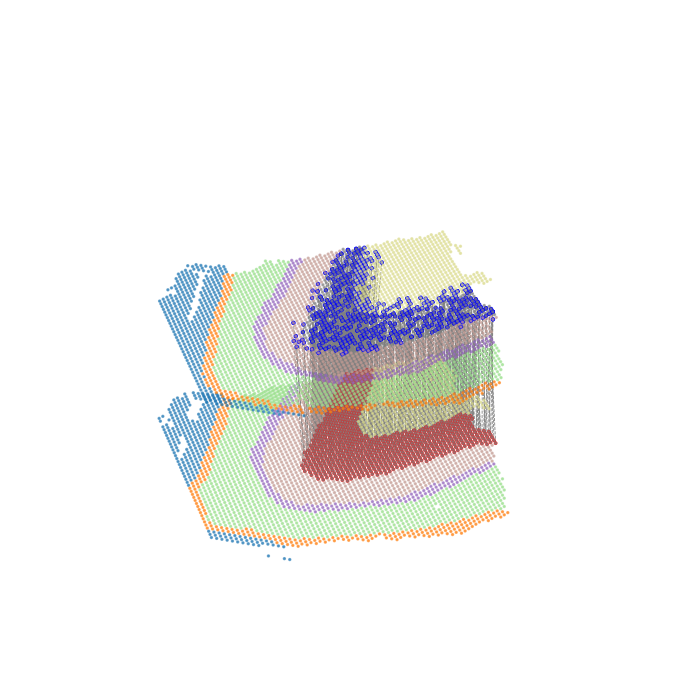

In [22]:
from lib_3d_OT.plot import *
all_arrow_ends,layer_1_pcloud_3D=plot_selected_cell_type_flow(pclouds_list, model, device,selected_cell_type='Layer_6',finaltruth=['Layer_6'],xlim=(-0.1, 1.1),ylim=(-0.1, 1.1),height_scale=1,size=2,alpha=0.6,
    #save_path='/home/dbj/DPLFC/'
)

In [23]:
chamfer_dist = chamfer_distance(all_arrow_ends,layer_1_pcloud_3D)

print(f"chamfer distance: {chamfer_dist}")

chamfer distance: 0.00039949498587779836


### WM alignment result

Number of arrow ends: 513
Layer 1 points count: 625


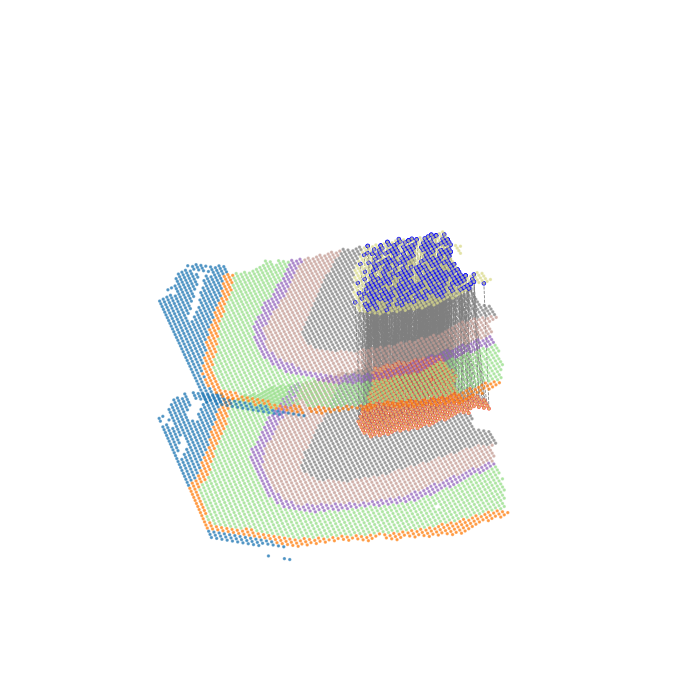

In [24]:
from lib_3d_OT.plot import *
all_arrow_ends,layer_1_pcloud_3D=plot_selected_cell_type_flow(pclouds_list, model, device,selected_cell_type='WM',finaltruth=['WM'],xlim=(-0.1, 1.1),ylim=(-0.1, 1.1),height_scale=1,size=2,alpha=0.6,
    #save_path='/home/dbj/DPLFC/'
)

In [25]:
chamfer_dist = chamfer_distance(all_arrow_ends,layer_1_pcloud_3D)

print(f"chamfer distance: {chamfer_dist}")

chamfer distance: 0.00018394429114206693
